In [135]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from numpy.random import uniform, normal, randn, rayleigh
from numpy.linalg import norm
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
fontsize_general = 16
plt.rcParams.update({'font.size': fontsize_general,
                     'axes.titlesize': fontsize_general,
                     'axes.labelsize': fontsize_general,
                     'axes.labelpad': 8,
                     'lines.linewidth': 2,
                     'lines.markersize': 8,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in'})


In [136]:
from scipy import constants
r_JP = 1.5e-6/2 #m
T = 300 # K
viscosity_water = 2.414*10**(247.8/(T-140)-5) # Ns/m^2
k_B = constants.k
#mu_trans = 1/(6*np.pi * viscosity_water *r_JP) #m/Ns
#mu_rot = 1/(8*np.pi * viscosity_water *r_JP**3) #1/Nsm
#print('mu_trans = {:.3} Ns/m'.format(mu_trans))

#D_t = k_B*T*mu_trans
#D_r = k_B*T*mu_rot

# define the simulation

In [137]:
class LangevinSimulator_Ellipsoids:
    def __init__(self):
        #system parameters
        # physical parameters
        from scipy import constants
        
        # Set a seed for the generator of random numbers
        #np.random.seed(0)
        
        # Simualtion parameters
        self.dt = 0.02 # [s]
        self.steps = 100
        
        # Ellipsoid parameters
        self.L_major = 3 # [µm]
        self.L_minor = 0.5 # [µm]
        self.T = 300 # [K]
        
        # translational diffusion coeff.
        self.Dt_minor = 0.1 # [µm^2/s]
        self.Dt_major = 0.2 # [µm^2/s]
        
        # translational friction coeff.
        self.mu_trans_minor = self.Dt_minor/constants.k/self.T # [µm / Ns]
        self.mu_trans_major = self.Dt_major/constants.k/self.T # [µm / Ns]
        
        # rotational diffusion coeff.
        self.Dr_minor = 0.2 # [1/s]
        self.Dr_major = 2 # [1/s]
        
        # rotational friction coeff.
        self.mu_rot_minor = self.Dr_minor/constants.k/self.T  # [1 / Nsµm]
        self.mu_rot_major = self.Dr_major/constants.k/self.T  # [1 / Nsµm]
        
        # activity parameters
        self.v = 1
        self.k_alignment = np.sqrt(self.Dr_major*self.dt) #1
        
        #initial conditions
        self.x0 = 0
        self.y0 = 0
        
        self.azimuthal0 = 0
        self.polar0 = 0
        
    def run_overdamped(self):
        import time
        inital_time = time.time()
        
        steps = self.steps
        dt = self.dt
        
        x, y, z = np.empty([3, steps+1])
        azimuthal, polar = np.empty([2, steps+1])
        
        x[0], y[0] = self.x0, self.y0
        azimuthal[0], polar[0] = self.azimuthal0, self.polar0
        
        #translational noise
        bath_trans_minor = np.sqrt(2*self.Dt_minor*dt) * normal(size=(steps+1)) 
        bath_trans_major = np.sqrt(2*self.Dt_major*dt) * normal(size=(steps+1))
        
        #angle noise
        bath_angle_incr_minor = np.sqrt(2*self.Dr_minor*dt) * normal(size=steps+1)
        bath_angle_incr_major = np.sqrt(2*self.Dr_major*dt) * normal(size=steps+1)
        
        progress = 1
        for i in range(1, steps+1):
            
            if (i*100)//steps == progress:
                print('{:.2g} % progress; computation time: {:.3g} min; aprox total time = {:.3g} min'.format(progress, (time.time() - inital_time)/60, (time.time() - inital_time)/60/progress*100))
                progress += 1
            
            # POSITION UPDATE
            x[i] = x[i-1] + ( bath_trans_minor[i-1]*np.cos(azimuthal[i-1]) 
                             - bath_trans_major[i-1]*np.sin(azimuthal[i-1])
                             + self.v*dt * np.cos(azimuthal[i-1]) * np.sin(polar[i-1])
                            )
            y[i] = y[i-1] + ( bath_trans_minor[i-1]*np.sin(azimuthal[i-1]) 
                             + bath_trans_major[i-1]*np.cos(azimuthal[i-1])
                             + self.v*dt * np.sin(azimuthal[i-1]) * np.sin(polar[i-1])
                            )
            
            # ORIENTATION UPDATE
            polar[i] = polar[i-1] + bath_angle_incr_major[i-1] + self.v*dt * self.k_alignment * np.cos(polar[i-1]) * np.sign(np.sin(polar[i-1]))
            azimuthal[i] = azimuthal[i-1] + bath_angle_incr_minor[i-1]
            
            
            ## APPLY WALL CONFINEMENT - circular soft wall (wall strentgh = 1 is already quite hard...)
            #r_sq = x[i]**2 + y[i]**2
            #wall_strength = 1
            #if r_sq > self.wall_radius_sq:
            #    x[i] += -x[i]/self.wall_radius * np.sqrt(D*dt) * wall_strength
            #    y[i] += -y[i]/self.wall_radius * np.sqrt(D*dt) * wall_strength
            
            
        self.Calculation_time_min = (time.time() - inital_time)/60
        self.x, self.y = x, y
        self.polar, self.azimuthal = polar, azimuthal

        
    def save(self, filename):
        np.savetxt(filename, np.c_[self.x, self.y, self.polar, self.azimuthal], header="# x, y, polar, azimuthal")
        
        
        

# run the sim

In [138]:
Lsim = LangevinSimulator_Ellipsoids()
Lsim.steps = int(1e5)
Lsim.k_alignment = 5

Lsim.run_overdamped()

1 % progress; computation time: 0.000754 min; aprox total time = 0.0754 min
2 % progress; computation time: 0.00122 min; aprox total time = 0.061 min
3 % progress; computation time: 0.00163 min; aprox total time = 0.0543 min
4 % progress; computation time: 0.00206 min; aprox total time = 0.0516 min
5 % progress; computation time: 0.00246 min; aprox total time = 0.0493 min
6 % progress; computation time: 0.00282 min; aprox total time = 0.0469 min
7 % progress; computation time: 0.00313 min; aprox total time = 0.0447 min
8 % progress; computation time: 0.00347 min; aprox total time = 0.0433 min
9 % progress; computation time: 0.00379 min; aprox total time = 0.0421 min
10 % progress; computation time: 0.00411 min; aprox total time = 0.0411 min
11 % progress; computation time: 0.00443 min; aprox total time = 0.0402 min
12 % progress; computation time: 0.00476 min; aprox total time = 0.0397 min
13 % progress; computation time: 0.00509 min; aprox total time = 0.0391 min
14 % progress; comput

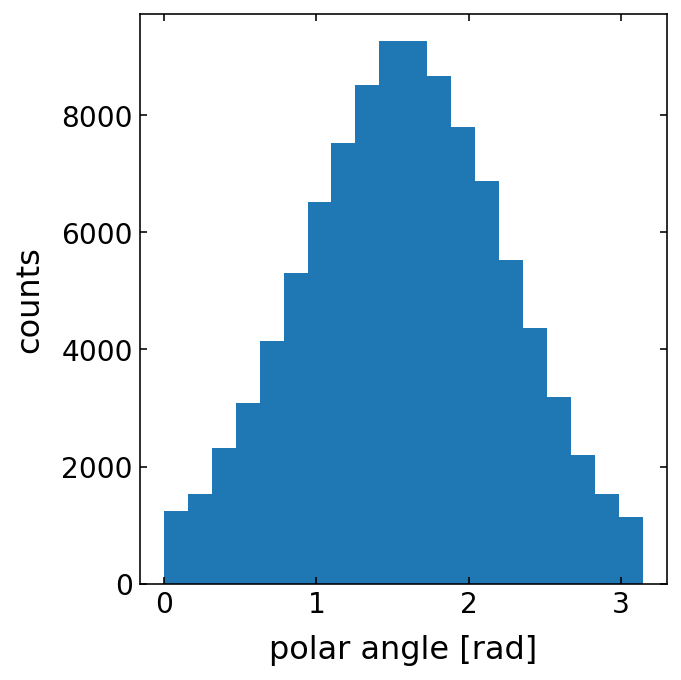

In [139]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.set_ylabel('counts')
ax.set_xlabel('polar angle [rad]')

ax.hist(np.arccos(np.cos(Lsim.polar)), bins = 20)
plt.tight_layout()
#plt.savefig('hist_polar_angle.pdf')
plt.show()

In [140]:
nth = int(1)
dt_s = Lsim.dt * nth
print('nth',nth)
df = pd.DataFrame({'x': Lsim.x[::nth]
                      ,'y':Lsim.y[::nth]
                      ,'nz':np.cos(Lsim.polar[::nth])
                      ,'nx_particle_frame':np.sin(Lsim.polar[::nth])
                      ,'orientation':Lsim.azimuthal[::nth]
                      ,'direction_measure': np.sin(Lsim.polar[::nth])
                      ,'minor_axis_length': np.zeros(len(Lsim.x))[::nth] +Lsim.L_minor
                      ,'major_axis_length': np.zeros(len(Lsim.x))[::nth] +Lsim.L_major
                      ,'summed_intensity': np.zeros(len(Lsim.x))[::nth] +np.cos(Lsim.polar[::nth]) + 2
                      ,'frame':np.arange(0,int(len(Lsim.x)/nth))
                      ,'particle': np.zeros(len(Lsim.x))[::nth]
                       ,'int_sum':np.zeros(len(Lsim.x))[::nth] +np.cos(Lsim.polar[::nth]) + 2
                      })

nth 1


In [145]:
metadata = pd.DataFrame([{'sim':'yes'}])

# safe to csv similar to trackerlab

please uncomment the to_csv   it is commented here because it would generate files in the github dir here.

In [146]:
file = 'Ellipsoid_sim_features.csv'

#metadata.to_csv(file, mode='w')  
#df.to_csv(file, mode='a')

In [147]:
def loadCSVFeatures(file):
    comments = ''
    with open(file) as f:
        row_count = 0
        row = f.readline()
        while row.startswith('#'):
            comments += row[1:] # remove leading # and append to comments
            row = f.readline()
            row_count += 1
    metadata = pd.read_csv(file, skiprows=row_count, nrows=1, index_col=0).to_dict('records')[0]
    features = pd.read_csv(file, skiprows=row_count + 2, index_col=0)
    return features, metadata, comments
features, metadata, comments = loadCSVFeatures(file)

In [148]:
metadata

{'sim': 'yes'}

In [149]:
comments

''

In [150]:
features.head(1)

,x,y,nz,nx_particle_frame,orientation,direction_measure,minor_axis_length,major_axis_length,summed_intensity,frame,particle,int_sum
0,0.0,0.0,1.0,0.0,0.0,0.0,0.5,3.0,3.0,0,0.0,3.0
